# Scenario description

In [1]:
import numpy as np
import pandas as pd

TODO
* [ ] define scenarios, collect sources
* [ ] vom assumptions
* [ ] carrier_prices
* [ ] efficiencies
* [ ] lca

In [3]:
cost_inputs = pd.read_csv('../data/cost_inputs.csv', index_col=0)
cost_inputs

,scenario,uncertainty,technology,efficiency_el,efficiency_th,overnight_cost,overnight_cost_unit,lifetime,lifetime_unit,wacc,fom,fom_unit,vom,vom_unit,carrier_price,carrier_price_unit,source,comment
0,scenario_basic,reference,chp_coal,0.3,NaN,NaN,Eur/kW_th,NaN,a,0.07,NaN,%/a,NaN,Eur/kWh,NaN,Eur/kWh,NaN,NaN
1,scenario_basic,reference,chp_gas,0.4,0.30,600.0,Eur/kW_th,25.0,a,0.07,3.0,%/a,0.003,Eur/kWh,0.0216,Eur/kWh,Brown2018,efficiencies: own assumption
2,scenario_basic,reference,gas_boiler_central,0.0,0.90,63.0,Eur/kW_th,22.0,a,0.07,1.0,%/a,0.003,Eur/kWh,0.0216,Eur/kWh,Brown2018,NaN
3,scenario_basic,reference,gas_boiler_decentral,0.0,0.90,175.0,Eur/kW_th,20.0,a,0.04,2.0,%/a,0.003,Eur/kWh,0.0216,Eur/kWh,Brown2018,NaN
4,scenario_basic,reference,pth_resistive,0.0,0.90,100.0,Eur/kW_th,20.0,a,0.07,2.0,%/a,0.000,Eur/kWh,0.0850,Eur/kWh,Brown2018,NaN
5,scenario_basic,reference,pth_heat_pump_central,0.0,2.00,700.0,Eur/kW_th,20.0,a,0.07,3.5,%/a,0.000,Eur/kWh,0.0850,Eur/kWh,Brown2018,NaN
6,scenario_basic,reference,pth_heat_pump_decentral,0.0,2.00,1050.0,Eur/kW_th,20.0,a,0.04,3.5,%/a,0.000,Eur/kWh,0.0850,Eur/kWh,Brown2018,NaN
7,scenario_basic,reference,heat_distribution_costs,0.0,0.88,NaN,Eur/kW_th,NaN,a,0.07,NaN,%/a,NaN,Eur/kWh,0.0000,Eur/kWh,NaN,NaN


In [4]:
emission_inputs = pd.read_csv('../data/emission_inputs.csv', index_col=0)
emission_inputs

,scenario,uncertainty,technology,efficiency,spec_emission_cap,spec_emission_cap_unit,lifetime,lifetime_unit,spec_emission_var,spec_emission_var_unit,source
0,scenario_basic,reference,chp_coal,NaN,NaN,tCO2/kW,NaN,a,NaN,tCO2/kW,NaN
1,scenario_basic,reference,chp_gas,0.468,600.0,tCO2/kW,25.0,a,25.0,tCO2/kW,Brown2018
2,scenario_basic,reference,gas_boiler_central,0.900,63.0,tCO2/kW,22.0,a,22.0,tCO2/kW,Brown2018
3,scenario_basic,reference,gas_boiler_decentral,0.900,175.0,tCO2/kW,20.0,a,20.0,tCO2/kW,Brown2018
4,scenario_basic,reference,pth_resistive,0.900,100.0,tCO2/kW,20.0,a,20.0,tCO2/kW,Brown2018
5,scenario_basic,reference,pth_heat_pump_central,2.000,700.0,tCO2/kW,20.0,a,20.0,tCO2/kW,Brown2018
6,scenario_basic,reference,pth_heat_pump_decentral,2.000,1050.0,tCO2/kW,20.0,a,20.0,tCO2/kW,Brown2018
7,scenario_basic,reference,heat_distribution_costs,NaN,NaN,tCO2/kW,NaN,a,NaN,tCO2/kW,NaN


In [7]:
table_dict = {
    'chp_coal': 'CHP coal',
    'chp_gas': 'CHP gas',
    'gas_boiler_central': 'Gas boiler central',
    'gas_boiler_decentral': 'Gas boiler decentral',
    'pth_resistive': 'PtH resistive',
    'pth_heat_pump_central': 'PtH heat pump central',
    'pth_heat_pump_decentral': 'PtH heat pump decentral',
    'heat_distribution_costs': 'Heat distribution costs'
}

cost_inputs = cost_inputs.replace(table_dict)
emission_inputs = emission_inputs.replace(table_dict)

In [8]:
def annuity(capex, n, wacc):
    """Calculate the annuity.

    annuity = capex * (wacc * (1 + wacc) ** n) / ((1 + wacc) ** n - 1)

    Parameters
    ----------
    capex : float
        Capital expenditure (NPV of investment)
    n : int
        Number of years that the investment is used (economic lifetime)
    wacc : float
        Weighted average cost of capital

    Returns
    -------
    float : annuity

    """
    return capex * (wacc * (1 + wacc) ** n) / ((1 + wacc) ** n - 1)


def get_cost_results(cost_inputs,
                     inst_capacity,
                     full_load_hours,
                     annuity,
                     factor_el,
                     factor_th):
    r""""
    
    Params
    -------
    cost_inputs : pd.DataFrame
    inst_capacity : float
    full_load_hours : float
    annuity : function
    factor_el : float
    factor_th : float
    
    Returns
    -------
    results : pd.DataFrame
    """
    total_costs = lambda x: annuity(x['overnight_cost'], x['lifetime'], x['wacc'])*inst_capacity \
        + x['overnight_cost']*x['fom']*inst_capacity \
        + x['vom']*full_load_hours + x['carrier_price']*1/x['efficiency']*full_load_hours
    lcoe = lambda x: factor_el * total_costs(x)/(full_load_hours*inst_capacity)
    lcoh = lambda x: factor_th * total_costs(x)/(full_load_hours*inst_capacity)

    results = pd.DataFrame()
    results['technology'] = cost_inputs['technology']
    results['inst_capacity'] = inst_capacity
    results['full_load_hours'] = full_load_hours
    results['factor_el'] = factor_el  
    results['factor_th'] = factor_th         
    results['total_costs'] = cost_inputs.apply(total_costs, 1)
    results['total_costs_unit'] = 'Eur'
    results['lcoe'] = cost_inputs.apply(lcoe, 1)
    results['lcoe_unit'] = 'Eur/kW_el'
    results['lcoh'] = cost_inputs.apply(lcoh, 1)
    results['lcoh_unit'] = 'Eur/kW_th'
    return results


def get_emission_results(emission_inputs,
                         inst_capacity,
                         full_load_hours):
    r""""
    
    Params
    -------
    emission_inputs : pd.DataFrame
    inst_capacity : float
    full_load_hours : float
    
    Returns
    -------
    results: pd.DataFrame
    """
    results = pd.DataFrame()
    results['technology'] = emission_inputs['technology']
    results['inst_capacity'] = inst_capacity
    results['full_load_hours'] = full_load_hours
    emissions = lambda x: x['spec_emission_cap']*inst_capacity + x['spec_emission_var']*full_load_hours
    results['emissions'] = emission_inputs.apply(emissions, 1)
    results['emissions_unit'] = 'tCO2'
    return results


inst_capacity = 1.
full_load_hours = 4000
factor_el = 0.5
factor_th = 0.5
cost_results = get_cost_results(cost_inputs, inst_capacity, full_load_hours, annuity, factor_el, factor_th)
emission_results = get_emission_results(emission_inputs, inst_capacity, full_load_hours)

In [9]:
import seaborn as sns

cm = sns.light_palette("red", as_cmap=True)
cost_results.style.background_gradient(cmap=cm)

/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,technology,inst_capacity,full_load_hours,factor_el,factor_th,total_costs,total_costs_unit,lcoe,lcoe_unit,lcoh,lcoh_unit
0,CHP coal,1,4000,0.5,0.5,nan,Eur,nan,Eur/kW_el,nan,Eur/kW_th
1,CHP gas,1,4000,0.5,0.5,2048.1,Eur,0.256013,Eur/kW_el,0.256013,Eur/kW_th
2,Gas boiler central,1,4000,0.5,0.5,176.696,Eur,0.0220869,Eur/kW_el,0.0220869,Eur/kW_th
3,Gas boiler decentral,1,4000,0.5,0.5,470.877,Eur,0.0588596,Eur/kW_el,0.0588596,Eur/kW_th
4,PtH resistive,1,4000,0.5,0.5,nan,Eur,nan,Eur/kW_el,nan,Eur/kW_th
5,PtH heat pump central,1,4000,0.5,0.5,nan,Eur,nan,Eur/kW_el,nan,Eur/kW_th
6,PtH heat pump decentral,1,4000,0.5,0.5,nan,Eur,nan,Eur/kW_el,nan,Eur/kW_th
7,Heat distribution costs,1,4000,0.5,0.5,nan,Eur,nan,Eur/kW_el,nan,Eur/kW_th


In [10]:
cm = sns.light_palette("red", as_cmap=True)
emission_results.style.background_gradient(cmap=cm)

,technology,inst_capacity,full_load_hours,emissions,emissions_unit
0,CHP coal,1,4000,nan,tCO2
1,CHP gas,1,4000,100600,tCO2
2,Gas boiler central,1,4000,88063,tCO2
3,Gas boiler decentral,1,4000,80175,tCO2
4,PtH resistive,1,4000,80100,tCO2
5,PtH heat pump central,1,4000,80700,tCO2
6,PtH heat pump decentral,1,4000,81050,tCO2
7,Heat distribution costs,1,4000,nan,tCO2


# Plot total costs/emissions vs. full_load_hours 

In [11]:
cost_results = pd.DataFrame()
for full_load_hours in [1000,4000,8000]:
    cost_results = cost_results.append(get_cost_results(cost_inputs, inst_capacity, full_load_hours, annuity, factor_el, factor_th))

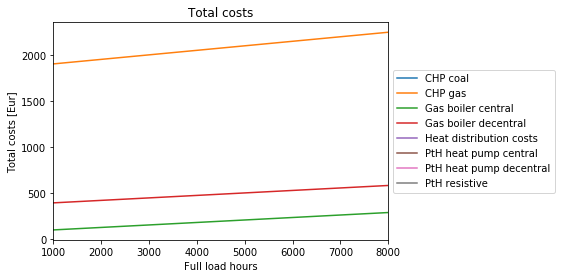

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for name, group in cost_results.groupby('technology'):
    group.plot(x='full_load_hours',
               y='total_costs',
               label=name,
               ax=ax,
               legend=True)
ax.set_xlabel('Full load hours')
ax.set_title('Total costs')
ax.set_ylabel('Total costs [Eur]')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [13]:
emission_results = pd.DataFrame()
for full_load_hours in [1000,4000,8000]:
    emission_results = emission_results.append(get_emission_results(emission_inputs, inst_capacity, full_load_hours))

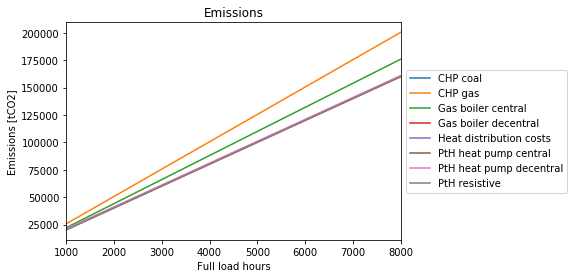

In [14]:
fig, ax = plt.subplots()
for name, group in emission_results.groupby('technology'):
    group.plot(x='full_load_hours',
               y='emissions',
               label=name,
               ax=ax,
               legend=True)
ax.set_xlabel('Full load hours')
ax.set_ylabel('Emissions [tCO2]')
ax.set_title('Emissions')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Minimal oemof model

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from oemof.solph import (Source, Sink, Transformer, Bus, Flow,
                         Model, EnergySystem)
from oemof.solph.components import GenericStorage
import oemof.outputlib as outputlib
import oemof.graph as graph

solver = 'cbc'

# set timeindex and create data
periods = 20
datetimeindex = pd.date_range('1/1/2019', periods=periods, freq='H')
x = np.arange(periods)
demand = np.zeros(20)
demand[-3:] = 2
wind = np.zeros(20)
wind[:3] = 3

timeseries = pd.DataFrame()

# set up EnergySystem
energysystem = EnergySystem(timeindex=datetimeindex)

b_el = Bus(label='electricity')
b_heat_1 = Bus(label='heat_1')
b_heat_2 = Bus(label='heat_2')
b_gas = Bus(label='gas', balanced=False)

sold_el = Sink(label='sold_el', inputs={b_el: Flow()})

chp = Transformer(label='chp',
                  inputs={b_gas: Flow()},
                  outputs={b_heat_1: Flow(),
                           b_el: Flow()}, 
                  conversion_factors={b_heat_1: 1,
                                      b_el: 1})
pth_central = Source(label='pth_central', outputs={b_heat_1: Flow(variable_costs=1e6)})

tes_central = GenericStorage(label='storage_central',
                      inputs={b_heat_1: Flow(variable_costs=0.0001)},
                      outputs={b_heat_1: Flow()},
                      nominal_storage_capacity=15,
                      initial_storage_level=0.75,
                      #min_storage_level=0.4,
                      #max_storage_level=0.9,
                      loss_rate=0.1,
                      loss_constant=0.,
                      inflow_conversion_factor=1.,
                      outflow_conversion_factor=1.)

dhn = Transformer(label='dhn',
                  inputs={b_heat_1: Flow()},
                  outputs={b_heat_2: Flow()}, 
                  conversion_factors={b_heat_2: 1})

pth_decentral = Source(label='pth_decentral', outputs={b_heat_2: Flow(variable_costs=1e6)})

tes_decentral = GenericStorage(label='storage_decentral',
                               inputs={b_heat_2: Flow(variable_costs=0.0001)},
                               outputs={b_heat_2: Flow()},
                               nominal_storage_capacity=15,
                               initial_storage_level=0.75,
                               #min_storage_level=0.4,
                               #max_storage_level=0.9,
                               loss_rate=0.1,
                               loss_constant=0.,
                               inflow_conversion_factor=1.,
                               outflow_conversion_factor=1.)

demand_th = Sink(label='demand_th',
                 inputs={b_heat_2: Flow(nominal_value=1,
                         actual_value=demand,
                         fixed=True)})

energysystem.add(b_el, b_heat_1, b_heat_2, b_gas, chp, sold_el,
                 pth_central, tes_central, dhn, 
                 pth_decentral, tes_decentral, demand_th)

/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
/home/jann/Desktop/repos/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and 

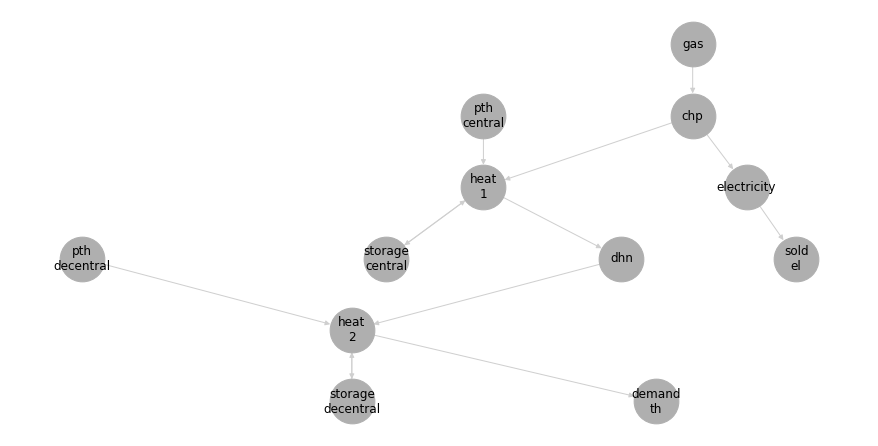

In [16]:
def draw_graph(grph, edge_labels=True, node_color='#AFAFAF',
               edge_color='#CFCFCF', plot=True,
               node_size=2000, node_shape='o', with_labels=True, arrows=True):
    """
    Draw a graph. This function will be removed in future versions.

    Parameters
    ----------
    grph : networkxGraph
        A graph to draw.
    edge_labels : boolean
        Use nominal values of flow as edge label
    node_color : dict or stringh
        Hex color code oder matplotlib color for each node. If string, all
        colors are the same.

    edge_color : string
        Hex color code oder matplotlib color for edge color.

    plot : boolean
        Show matplotlib plot.

    node_size : integer
        Size of nodes.

    with_labels : boolean
        Draw node labels.

    arrows : boolean
        Draw arrows on directed edges. Works only if an optimization_model has
        been passed.
    layout : string
        networkx graph layout, one of: neato, dot, twopi, circo, fdp, sfdp.
    """
    if type(node_color) is dict:
        node_color = [node_color.get(g, '#AFAFAF') for g in grph.nodes()]

    # set drawing options
    options = {
        #'prog': 'dot',
        'with_labels': with_labels,
        'node_color': node_color,
        'edge_color': edge_color,
        'node_size': node_size,
        'node_shape': node_shape,
        'arrows': arrows
    }

    labeldict = {node: node.replace('_', '\n') for node in grph.nodes}

    # draw graph
    plt.figure(figsize=(12, 6))
    pos = nx.drawing.nx_agraph.graphviz_layout(grph, prog='dot')
    nx.draw(grph, pos=pos, labels=labeldict, **options)

    # add edge labels for all edges
    if edge_labels is True and plt:
        labels = nx.get_edge_attributes(grph, 'weight')
        nx.draw_networkx_edge_labels(grph, pos=pos, edge_labels=labels)

    # show output
    if plot is True:
        plt.show()
        
gr = graph.create_nx_graph(energysystem)
draw_graph(gr)

In [17]:
optimization_model.write('/home/jann/Desktop/storage_model.lp', io_options={'symbolic_solver_labels': True})
optimization_model.solve(solver=solver,
                         solve_kwargs={'tee': False, 'keepfiles': False})
# get results
results = outputlib.processing.results(optimization_model)
string_results = outputlib.processing.convert_keys_to_strings(results)
sequences = {k:v['sequences'] for k, v in string_results.items()}
df = pd.concat(sequences, axis=1)
df

NameError: name 'optimization_model' is not defined

In [ ]:
# # print and plot results
# df = df.reset_index()

# fig, (ax1, ax2) = plt.subplots(2, 1)
# df[[('shortage', 'electricity', 'flow'),
#     ('wind', 'electricity', 'flow'),
#     ('storage', 'electricity', 'flow')]].plot.bar(ax=ax1, stacked=True, color=['y', 'b', 'k'])
# (-df[('electricity', 'storage', 'flow')]).plot.bar(ax=ax1, color='g')
# df[('electricity', 'demand', 'flow')].plot(ax=ax1, linestyle='', marker='o', color='r')
# ax1.set_ylim(-5, 5)
# ax1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# df[('storage', 'None', 'capacity')].plot.bar(ax=ax2)
# ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.tight_layout()
# plt.show()